In [7]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm

sys.path.append("..")
import evaluation_utils

In [3]:
BASELINE_ISM_DIR = "baseline.384_bins"
FINETUNED_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/classification_rep0_scheduler_rcprob_0.5_rsmax_3/ism"
PREDIXCAN_BETAS_PATH = (
    "../../predixcan_lite/h5_bins_384_chrom_split/384_bins_no_cv/coefs.csv"
)

In [5]:
predixcan_betas_df = pd.read_csv(PREDIXCAN_BETAS_PATH, index_col=0)
seen_genes = predixcan_betas_df["gene"].unique()
print(f"Assessing ISM/betas for {len(seen_genes)} genes")

Assessing ISM/betas for 400 genes


In [6]:
def compare_betas_with_predixcan(
    all_predixcan_betas_df: pd.DataFrame, ism_dir: str, gene: str
):
    gene_predixcan_betas_df = all_predixcan_betas_df[
        all_predixcan_betas_df["gene"] == gene
    ].set_index("variant")
    predixcan_betas = gene_predixcan_betas_df["beta"].to_dict()

    ism_path = os.path.join(ism_dir, f"{gene}.csv")
    ism_df = pd.read_csv(ism_path, index_col=0)
    isms = ism_df["ISM"].to_dict()

    assert set(predixcan_betas.keys()).issubset(set(isms.keys()))
    variants = list(predixcan_betas.keys())

    predixcan_betas_l = [predixcan_betas[v] for v in variants]
    isms_l = [isms[v] for v in variants]
    return (predixcan_betas_l, isms_l)

In [11]:
baseline_effsize_spearmans, baseline_effsize_pearsons = {}, {}
finetuned_effsize_spearmans, finetuned_effsize_pearsons = {}, {}

for g in tqdm(seen_genes):
    # Compare with baseline
    predixcan_betas, baseline_isms = compare_betas_with_predixcan(
        predixcan_betas_df, BASELINE_ISM_DIR, g
    )
    baseline_effsize_spearmans[g] = spearmanr(predixcan_betas, baseline_isms)[0]
    baseline_effsize_pearsons[g] = pearsonr(predixcan_betas, baseline_isms)[0]

    # Compare with finetuned
    predixcan_betas, finetuned_isms = compare_betas_with_predixcan(
        predixcan_betas_df, FINETUNED_ISM_DIR, g
    )
    finetuned_effsize_spearmans[g] = spearmanr(predixcan_betas, finetuned_isms)[0]
    finetuned_effsize_pearsons[g] = pearsonr(predixcan_betas, finetuned_isms)[0]

  0%|          | 0/400 [00:00<?, ?it/s]

In [15]:
def create_metrics_dataframe(
    baseline_effsize_spearmans: dict[str, float],
    baseline_effsize_pearsons: dict[str, float],
    finetuned_effsize_spearmans: dict[str, float],
    finetuned_effsize_pearsons: dict[str, float],
):
    gene_class_map = evaluation_utils.get_gene_to_class_map()

    genes = baseline_effsize_spearmans.keys()

    # Create a dataframe with the metrics
    metrics_df = pd.DataFrame(
        {
            "baseline_spearman": [baseline_effsize_spearmans[g] for g in genes],
            "baseline_pearson": [baseline_effsize_pearsons[g] for g in genes],
            "finetuned_spearman": [finetuned_effsize_spearmans[g] for g in genes],
            "finetuned_pearson": [finetuned_effsize_pearsons[g] for g in genes],
            "class": [gene_class_map[g] for g in genes],
        },
        index=genes,
    )
    return metrics_df

In [16]:
metrics_df = create_metrics_dataframe(
    baseline_effsize_spearmans,
    baseline_effsize_pearsons,
    finetuned_effsize_spearmans,
    finetuned_effsize_pearsons,
)

In [20]:
metrics_df.head()

,baseline_spearman,baseline_pearson,finetuned_spearman,finetuned_pearson,class
abhd10,0.121566,0.327896,0.121566,0.542859,yri_split
ac017104.1,-0.006804,0.033582,0.359068,0.496308,yri_split
ac079921.2,-0.068972,-0.015331,0.083540,0.021721,yri_split
ac091132.1,0.079221,0.018236,0.174287,0.175289,random_split
ac104653.1,0.026810,0.055703,0.129548,0.012834,yri_split


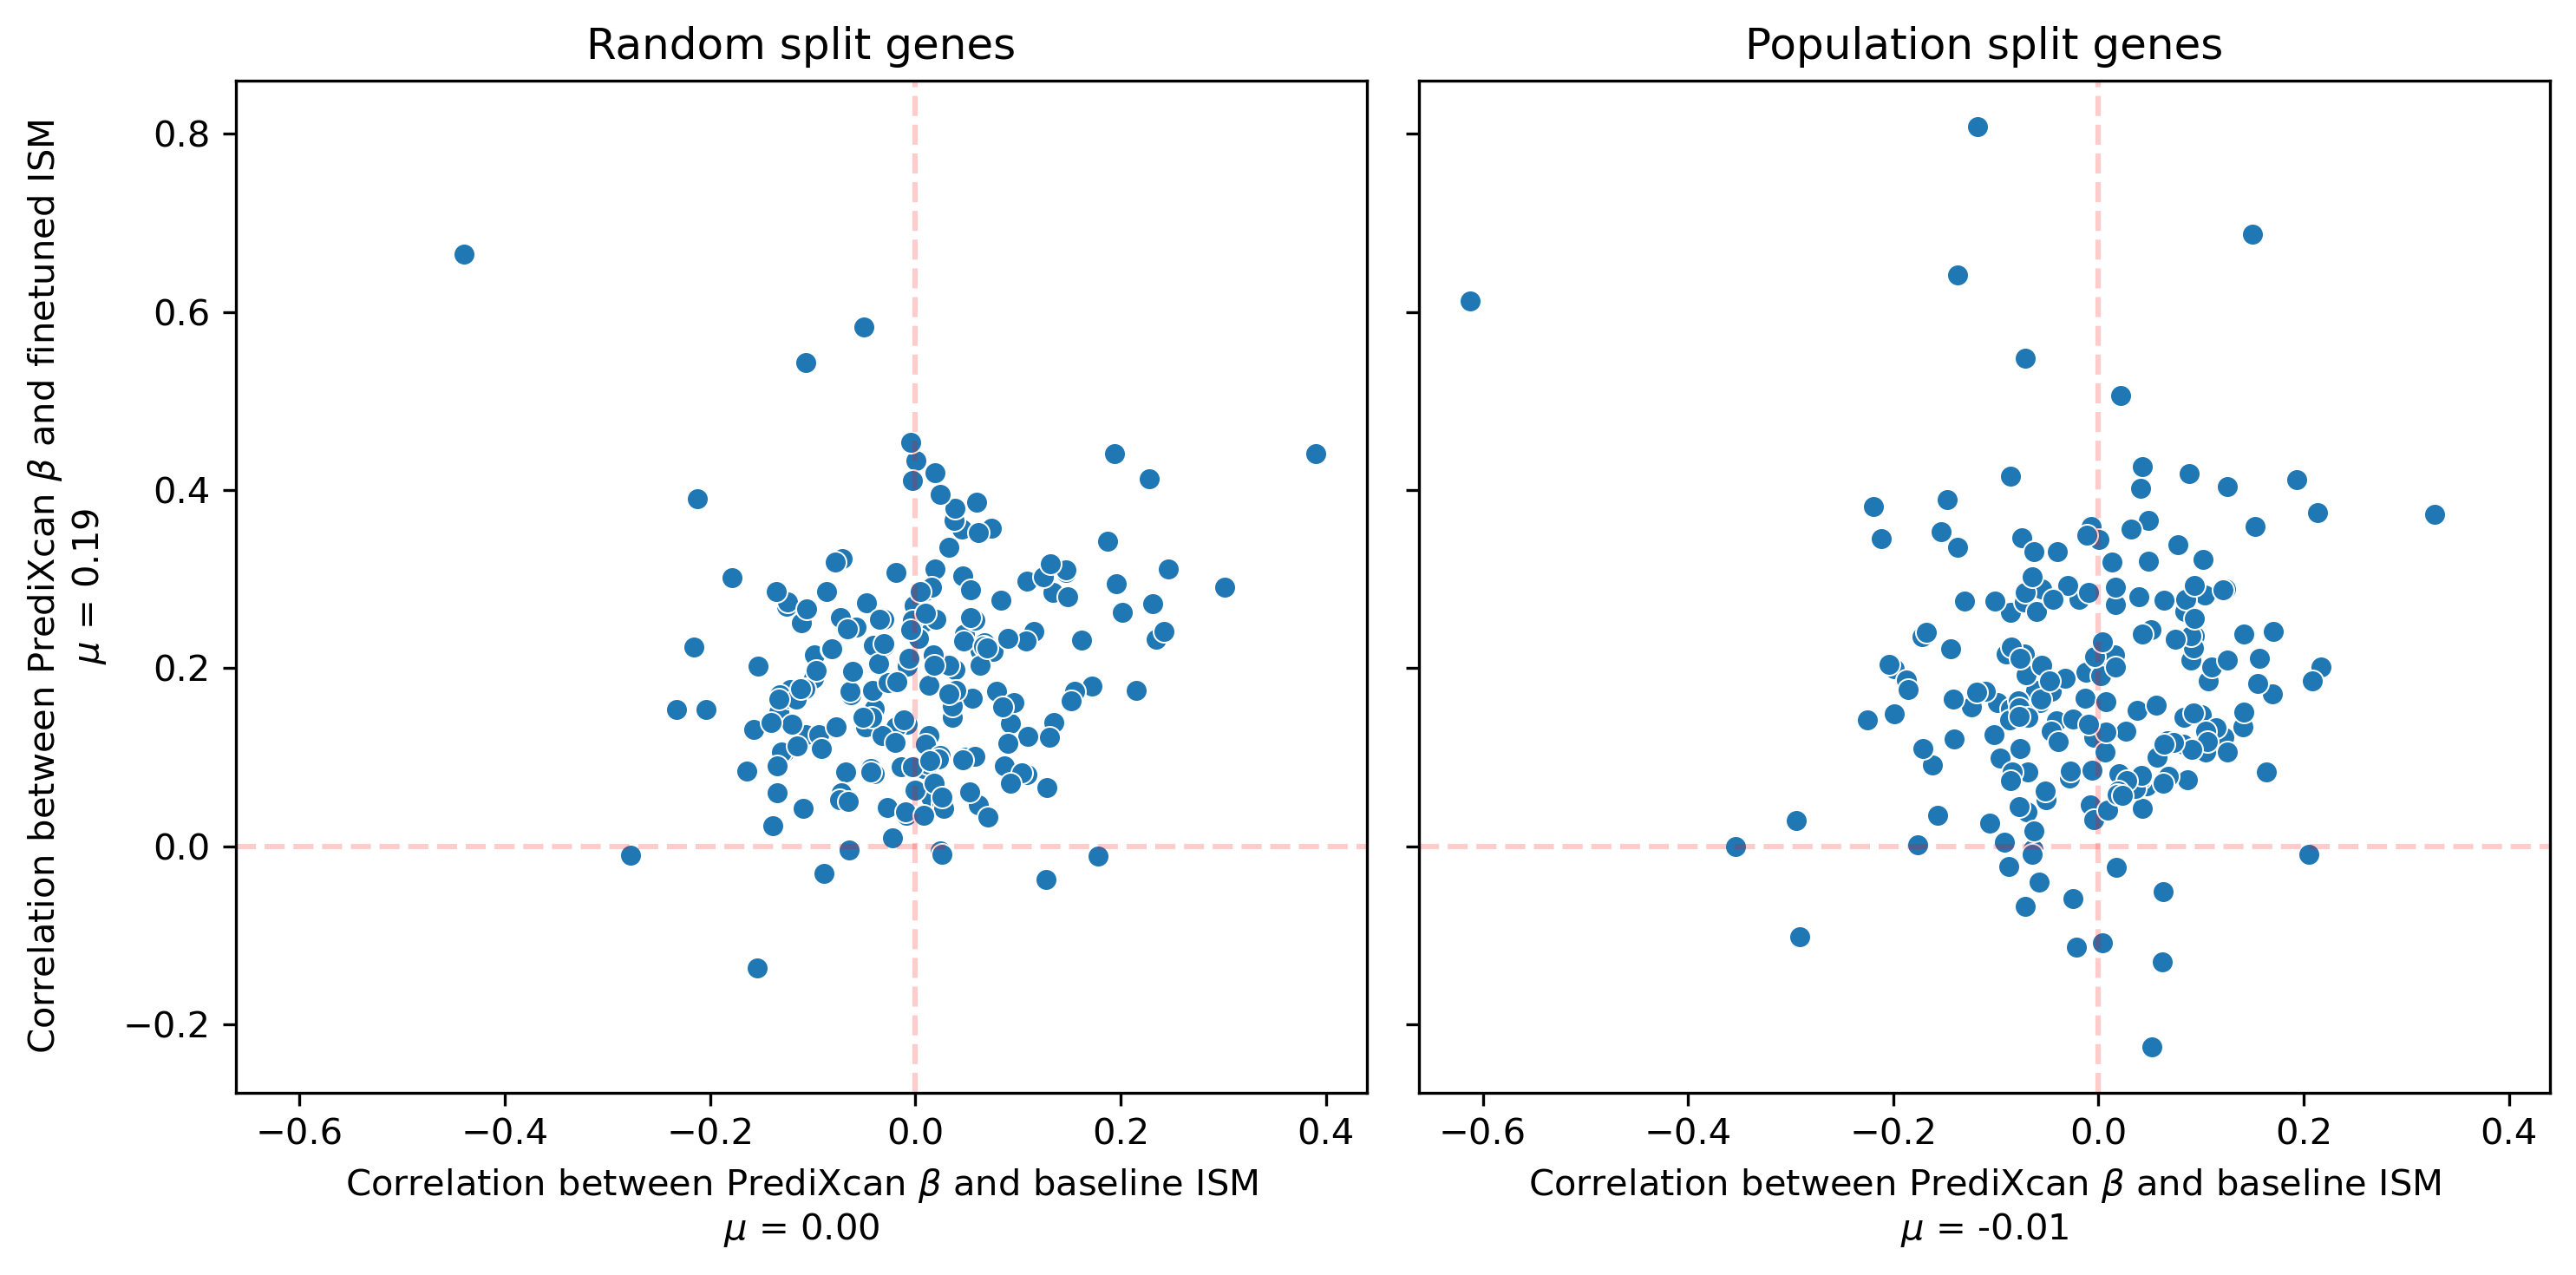

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), dpi=300, sharex=True, sharey=True)

random_split_metrics_df = metrics_df[metrics_df["class"] == "random_split"]
mean_baseline_spearman = random_split_metrics_df["baseline_spearman"].mean()
mean_finetuned_spearman = random_split_metrics_df["finetuned_spearman"].mean()
sns.scatterplot(
    data=random_split_metrics_df,
    x="baseline_spearman",
    y="finetuned_spearman",
    ax=axs[0],
)
axs[0].axhline(0.0, color="red", alpha=0.2, linestyle="--")
axs[0].axvline(0.0, color="red", alpha=0.2, linestyle="--")
axs[0].set(
    xlabel=r"Correlation between PrediXcan $\beta$ and baseline ISM"
    + "\n"
    + rf"$\mu$ = {mean_baseline_spearman:.2f}",
    ylabel=r"Correlation between PrediXcan $\beta$ and finetuned ISM"
    + "\n"
    + rf"$\mu$ = {mean_finetuned_spearman:.2f}",
    title="Random split genes",
)

yri_metrics_df = metrics_df[metrics_df["class"] == "yri_split"]
mean_baseline_spearman = yri_metrics_df["baseline_spearman"].mean()
mean_finetuned_spearman = yri_metrics_df["finetuned_spearman"].mean()
sns.scatterplot(
    data=yri_metrics_df,
    x="baseline_spearman",
    y="finetuned_spearman",
    ax=axs[1],
)
axs[1].axhline(0.0, color="red", alpha=0.2, linestyle="--")
axs[1].axvline(0.0, color="red", alpha=0.2, linestyle="--")
axs[1].set(
    xlabel=r"Correlation between PrediXcan $\beta$ and baseline ISM"
    + "\n"
    + rf"$\mu$ = {mean_baseline_spearman:.2f}",
    ylabel=r"Correlation between PrediXcan $\beta$ and finetuned ISM"
    + "\n"
    + rf"$\mu$ = {mean_finetuned_spearman:.2f}",
    title="Population split genes",
)

plt.tight_layout()
plt.show()